# Detecting Landing AI logo
This notebook uses the browser web camera to acquire images find the Landing AI logo using LandingLens cloud inference

In [50]:
#@title Set the following variables as needed for your setup
api_key         = "zm7ml657kh9a370k9liluxg9heuoufv"  #@param {type:"string"}
api_secret      = "1ccnesqy4em8dc32k2h2cu5kovdcd6palepaw4ugly6ttfl2fylu340x7ecja0"  #@param {type:"string"}
model_endpoint  =  "2d299622-434f-4ce9-b2eb-1142cdcfafcc" #@param {type:"string"}


In [53]:
%pip install landingai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Utility functions (temporary until we publish to cloud)

In [51]:
# Define function to aquire images from the web browser
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/tmp/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Acquire image from camera

<IPython.core.display.Javascript object>

Saved to /tmp/photo.jpg


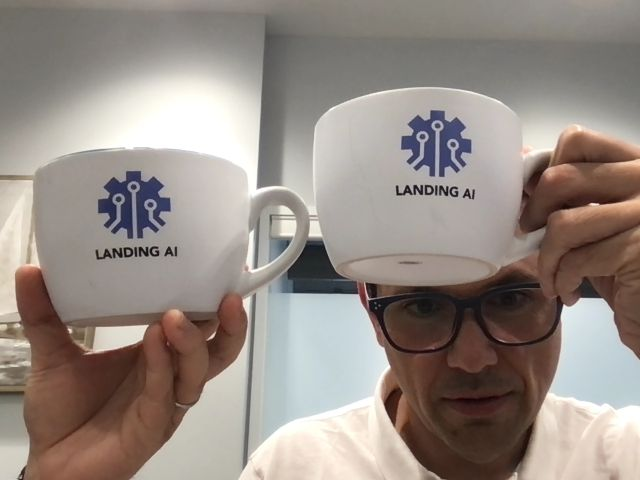

In [61]:
from IPython.display import Image
import cv2
from matplotlib import pyplot as plt

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

frame = cv2.imread(filename)

## Run the object detection model on LandingLens cloud

In [62]:
from landingai.predict import Predictor
from landingai.visualize import overlay_predictions
        
predictor = Predictor(model_endpoint, api_key, api_secret)

# Run prediction and show raw results
results = predictor.predict(frame)
display(results)

[ObjectDetectionPrediction(id='35c2d963-a02f-42dc-9628-d28682308971', score=0.7766109108924866, label_name='Landing Logo', label_index=1, bboxes=(93, 170, 176, 241)),
 ObjectDetectionPrediction(id='f2bd5d2f-4663-4f95-bcbe-c3185768079f', score=0.7588741779327393, label_name='Landing Logo', label_index=1, bboxes=(395, 109, 476, 177))]

## Visualize results

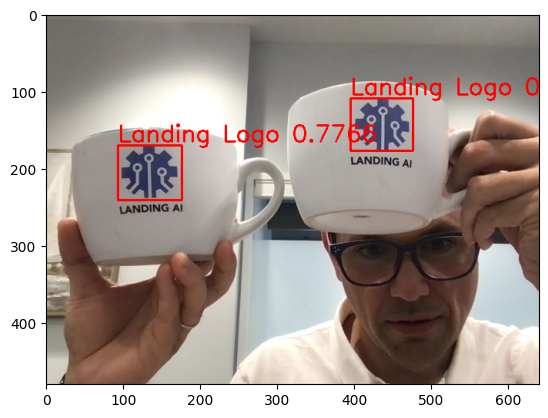

In [63]:
# Convert color space to RGB
frame2 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# Draw raw results on the original image
frame3 = overlay_predictions(results, image=frame2)

plt.imshow(frame3)
plt.show()


## Process results to count the number of logos

In [64]:
from IPython.display import display, Markdown
# Filter only high confidence detections and count them
filtered_results = [x for x in results if x.score  > 0.5] 
display(Markdown(f"# Found {len(filtered_results)} logos"))


# Found 2 logos